# 0.0 IMPORTS

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

import inflection

from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas_profiling    import ProfileReport
from sklearn.manifold    import TSNE

from matplotlib        import pyplot           as plt
from scipy.cluster     import hierarchy        as hc
from sklearn.neighbors import NearestNeighbors as nn
from sklearn           import cluster          as c
from sklearn           import mixture          as mx
from sklearn           import preprocessing    as pp
from sklearn           import metrics          as m
from sklearn           import decomposition    as dd
from sklearn           import ensemble         as en
from plotly            import express          as px

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [3]:
# Load dataset
df_raw = pd.read_csv( '/home/jeffsmedines/repos/loyalty_program/data/raw/Ecommerce.csv', encoding='unicode_escape' )

# Drop NA Column
df_raw = df_raw.drop( columns=['Unnamed: 8'] )

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
columns = df1.columns
new_columns = [inflection.underscore( x ) for x in columns]
df1.columns = new_columns

## 1.2 Data Dimensions

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA's

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA's

In [9]:
# Dataframe missing customer id
df_missing = df1.loc[df1['customer_id'].isna(), :].copy()

# Dataframe with customer id
df_not_missing = df1.loc[~df1['customer_id'].isna(), :].copy()

In [10]:
# Create dataframe reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000 + len( df_backup ), 1 )

# Merge original dataframe to reference
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# Coalesce (merge id columns)
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# Drop extre id columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'] )

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Data Types

In [12]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# Customer ID
df1['customer_id'] = df1['customer_id'].astype( int )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [15]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
ds = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ds.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ds

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> 1.7.2 Numerical Attributes - Investigating </font>

1. Quantity negativa. (talvez seja devolução)
2. Preço unitário igual a zero. (conferir se foi uma promoção)

### 1.7.2 Categorical Attributes

#### Invoice Number

In [16]:
# Invoice number with letters and unique values
a = len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates())

# Invoice number with letters
b = len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'])

# Quantity negative in rows with invoice number with letters
c11 = len(df1.loc[df1['quantity'] < 0, 'invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ))

print( f'Total number of unique invoice with letters: { a }' )
print( f'Total number of invoice with letters: { b }' )
print( f'Total number of negative quantity: { c11 }' )

Total number of unique invoice with letters: 3839
Total number of invoice with letters: 9291
Total number of negative quantity: 10624


#### Stock Code

In [17]:
# Stock code with letters
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code'].head()

0     85123A
2     84406B
3     84029G
4     84029E
45      POST
Name: stock_code, dtype: object

In [18]:
# Stock code only with letter
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Action: remove these codes

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [19]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [20]:
# Action: delet description because can't create any feature

#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

# 2.0 DATA FILTERING

In [23]:
df2 = df1.copy()

## 2.1 Categorical Attributes Filtering

In [24]:
# Stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# Drop description
df2 = df2.drop( columns='description', axis=1 )

# Map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] )]

In [25]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


## 2.2 Numerical Attributes Filtering

In [26]:
# Unit price < 0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]
df2 = df2[~df2['customer_id'].isin( [16446] )]

# Quantity
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchase = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0 FEATURE ENGINEERING

In [27]:
df3 = df2.copy()

## 3.1 Feature Creation

In [28]:
df_ref = df3.drop( columns=['invoice_no', 'stock_code', 'quantity',
                            'invoice_date', 'unit_price','country'], 
                             axis=1 ).drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross Revenue

In [29]:
# Gross Revenue
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency

In [30]:
# Recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop( columns=['invoice_date'], axis=1 )
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Total Quantity of  Purchases

In [31]:
# Purchases
df_freq = ( df2_purchase[['invoice_no', 'customer_id']].drop_duplicates()
                                                     .groupby( 'customer_id' )
                                                     .count()
                                                     .reset_index()
                                                     .rename( columns={'invoice_no': 'invoice_quantity'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id          0
gross_revenue       91
recency_days        91
invoice_quantity    91
dtype: int64

### 3.1.4 Total Quantity of Items Purchased

In [32]:
# Products purchased
df_freq = ( df2_purchase[['quantity', 'customer_id']].groupby( 'customer_id' )
                                                   .sum().reset_index()
                                                   .rename( columns={'quantity': 'items_quantity'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id          0
gross_revenue       91
recency_days        91
invoice_quantity    91
items_quantity      91
dtype: int64

### 3.1.5 Total Quantity of Products Purchased

In [33]:
# Products purchased
df_freq = ( df2_purchase[['stock_code', 'customer_id']].groupby( 'customer_id' )
                                                       .count()
                                                       .reset_index()
                                                       .rename( columns={'stock_code': 'products_quantity'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
invoice_quantity     91
items_quantity       91
products_quantity    91
dtype: int64

### 3.1.6 Average Ticket Value

In [34]:
# Avg ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
invoice_quantity     91
items_quantity       91
products_quantity    91
avg_ticket           91
dtype: int64

### 3.1.7 Returns

In [35]:
# Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'returns'} )
df_returns['returns'] = df_returns['returns'] * -1
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
invoice_quantity     91
items_quantity       91
products_quantity    91
avg_ticket           91
returns               0
dtype: int64

### 3.1.8 Average Recency Days

In [36]:
# Recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )

df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['next_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['next_date'] - x['invoice_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_date', 'next_customer_id'], axis=1 ).dropna()

# Average Recency Days
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# Merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
invoice_quantity       91
items_quantity         91
products_quantity      91
avg_ticket             91
returns                 0
avg_recency_days     2816
dtype: int64

### 3.1.9 Frequency Purchase

In [37]:
df_aux = ( df2_purchase[['customer_id',
                'invoice_no',
                'invoice_date']].drop_duplicates()
                                .groupby( 'customer_id' )
                                .agg( max_ = ( 'invoice_date', 'max' ),
                                      min_ = ( 'invoice_date', 'min' ),
                                      days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1),
                                      buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['days_', 'buy_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
invoice_quantity       91
items_quantity         91
products_quantity      91
avg_ticket             91
returns                 0
avg_recency_days     2816
frequency              91
dtype: int64

### 3.1.10 Unique Product Basket Size

In [38]:
df_aux = ( df2_purchase[['customer_id',
                         'invoice_no',
                         'stock_code']].groupby( 'customer_id' ) 
                                       .agg( n_purchases = ( 'invoice_no', 'nunique' ),
                                             n_products  = ( 'stock_code', 'count' ))
                                       .reset_index() )

# Calclate feature
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

df_aux.head()

,customer_id,n_purchases,n_products,avg_unique_basket_size
0,12346,1,1,1.00
1,12347,7,182,26.00
2,12348,4,27,6.75
3,12349,1,72,72.00
4,12350,1,16,16.00


### 3.1.11 Basket Size

In [39]:
# Create columns
df_aux = ( df2_purchase[['customer_id',
                         'invoice_no',
                         'quantity']].groupby( 'customer_id' ) 
                                     .agg( n_purchases = ( 'invoice_no', 'nunique' ),
                                           n_products  = ( 'quantity', 'sum' ))
                                     .reset_index() )

# Calclate feature
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_quantity            91
items_quantity              91
products_quantity           91
avg_ticket                  91
returns                      0
avg_recency_days          2816
frequency                   91
avg_unique_basket_size      91
avg_basket_size             91
dtype: int64

# 4.0 EXPLORATORY DATA ANALYSIS

In [40]:
df4 = df_ref.dropna().copy()

## 4.1 Univariate Analysis

In [41]:
# profile = ProfileReport( df4 )
# profile.to_file( '../reports/EDA/output_v2.html' )
# # v2 is after remove customer 16446

### 4.1.1 Gross Revenue

In [42]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,invoice_quantity,items_quantity,products_quantity,avg_ticket,returns,avg_recency_days,frequency,avg_unique_basket_size,avg_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,288.0,7.844444,0.203390,28.611111,2733.944444
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,0.0,14.680000,0.163043,7.183333,1068.733333
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,952.0,12.821429,0.127778,7.326087,1521.586957
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,3332.0,2.601399,0.533512,28.507538,403.331658
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,427.0,20.866667,0.063694,35.650000,3868.650000


In [43]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


In [44]:
np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])

278778.02

In [45]:
df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()

196556

### 4.1.2 Items Quantity

In [46]:
df4.loc[df4['items_quantity'] == 196844, :]

,customer_id,gross_revenue,recency_days,invoice_quantity,items_quantity,products_quantity,avg_ticket,returns,avg_recency_days,frequency,avg_unique_basket_size,avg_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,288.0,7.844444,0.20339,28.611111,2733.944444


In [47]:
df3.loc[df3['customer_id'] == 14646, :].sort_values( 'quantity', ascending=False ).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646


### 4.1.3 Avg Ticket

In [48]:
# df_ref.loc[df_ref['avg_ticket'] == 56157.5, :]

In [49]:
# df3.loc[df3['customer_id'] == 16446, :]
# remove this customer

### 4.1.4 Frequency

In [50]:
df_ref[df_ref['frequency'] == 17]

,customer_id,gross_revenue,recency_days,invoice_quantity,items_quantity,products_quantity,avg_ticket,returns,avg_recency_days,frequency,avg_unique_basket_size,avg_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,40.0,35.5,17.0,8.735294,50.970588


In [51]:
df3[df3['customer_id'] == 17850].sort_values( 'quantity', ascending=False ).head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850
3809,536685,71053,12,2016-11-30,3.39,United Kingdom,17850
4531,536790,37370,12,2016-11-30,1.06,United Kingdom,17850
4532,536790,21071,12,2016-11-30,1.06,United Kingdom,17850
4533,536790,21068,12,2016-11-30,1.06,United Kingdom,17850
290,536396,82494L,12,2016-11-29,2.55,United Kingdom,17850


### 4.1.5 Avg Basket Size

In [52]:
# df4[df4['avg_basket_size'] == 40498.5]
# the customer will be removed

## 4.2 Bivariate Analysis

In [53]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

In [54]:
# plt.figure( figsize=( 25, 12 ) )
# sns.pairplot( df42 )

- Notes
    - Frequency has low variance
    - Avg_ticket has low variance
    

## 4.3 Space Study

In [143]:
# df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'items_quantity', 'frequency', 'returns']
df43 = df4[ cols_selected ].copy()

In [144]:
mm = pp.MinMaxScaler()


df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
# df43['invoice_quantity']       = mm.fit_transform( df43[['invoice_quantity']] )
df43['items_quantity']         = mm.fit_transform( df43[['items_quantity']] )
# df43['products_quantity']      = mm.fit_transform( df43[['products_quantity']] )
# df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']] )
df43['returns']                = mm.fit_transform( df43[['returns']] )
# df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency']              = mm.fit_transform( df43[['frequency']] )
# df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )
# df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']] )

X = df43.copy()

### 4.3.1 PCA

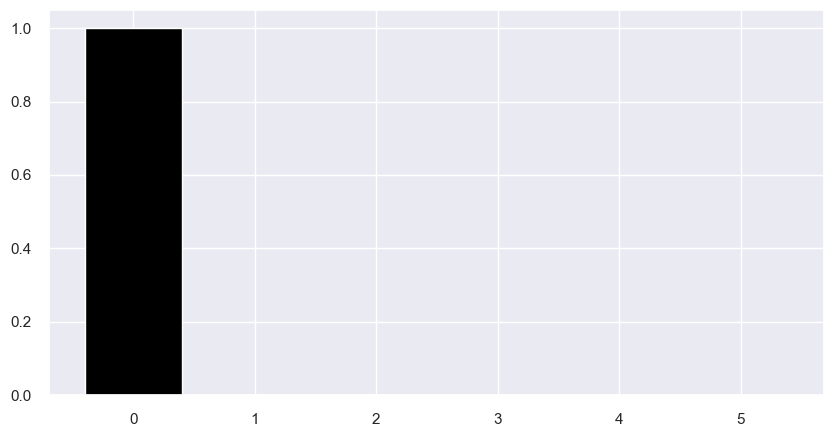

In [145]:
# PCA Definition
pca = dd.PCA( n_components=X.shape[1] )

# PCA training
principal_components = pca.fit_transform( X )

# Plot Explained Variables
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

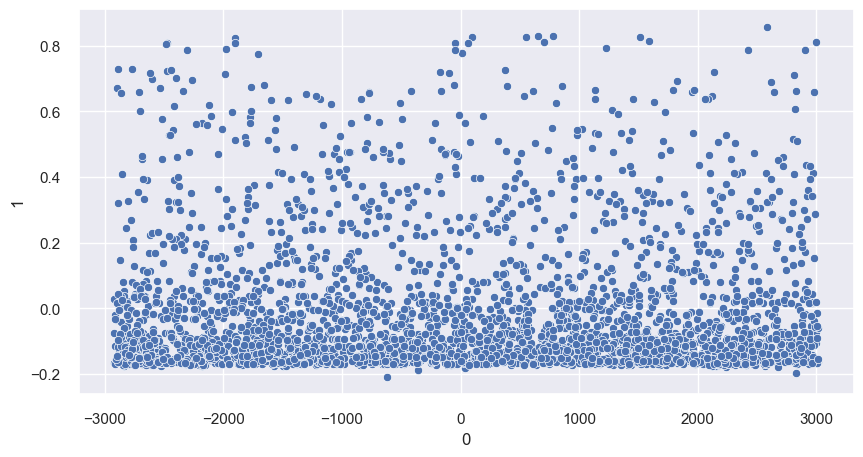

In [146]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

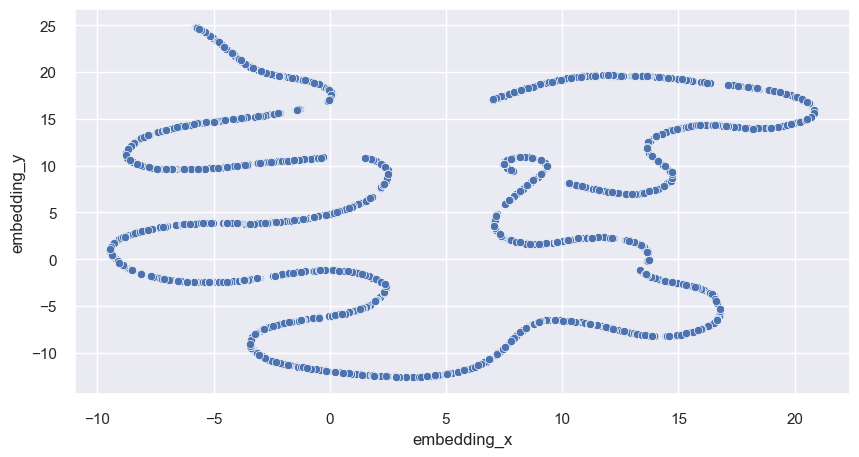

In [147]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_pca)

### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

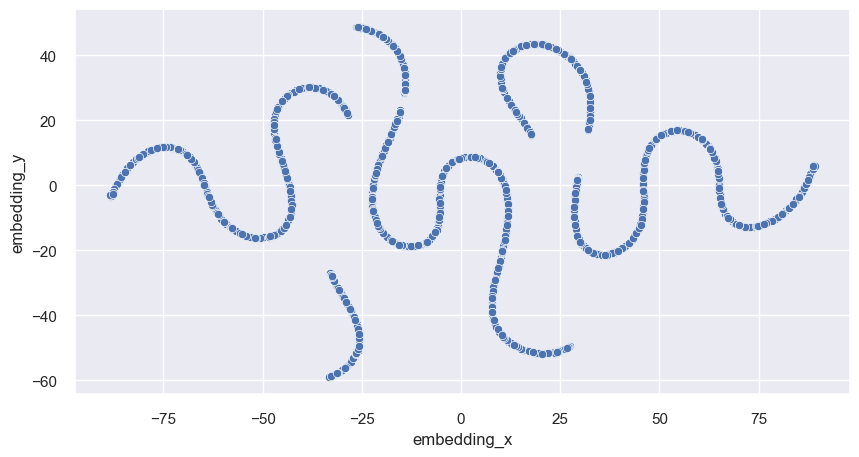

In [148]:
reducer = TSNE( n_components=2, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_pca)

### 4.3.4 Tree-Based Embedding

In [159]:
# Traning Dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 ).copy()
y = df43['gross_revenue'].copy()

# Model Definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# Model Training
rf_model.fit( X, y )

RandomForestRegressor(random_state=42)

In [160]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

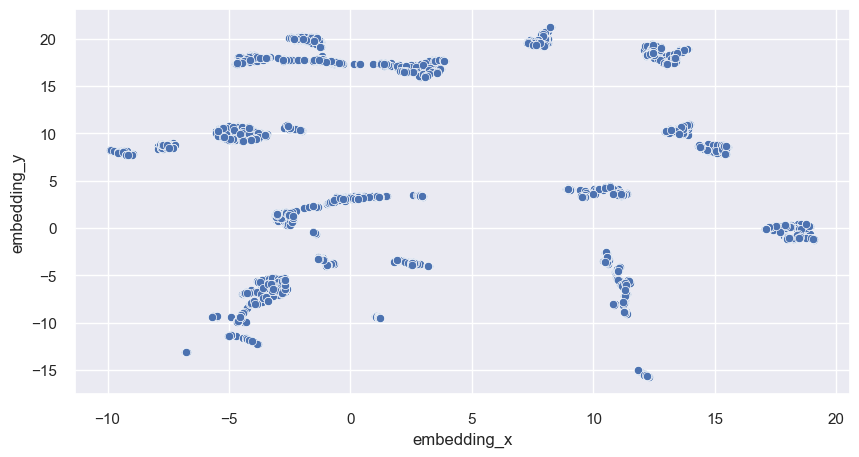

In [161]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_tree)

# 5.0 DATA PREPARATION

In [162]:
# df5 = df4.copy()
df5 = df_tree.copy()

In [163]:
# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

# df5['gross_revenue']          = mm.fit_transform( df5[['gross_revenue']] )
# df5['recency_days']           = mm.fit_transform( df5[['recency_days']] )
# df5['invoice_quantity']       = mm.fit_transform( df5[['invoice_quantity']] )
# df5['items_quantity']         = mm.fit_transform( df5[['items_quantity']] )
# df5['products_quantity']      = mm.fit_transform( df5[['products_quantity']] )
# df5['avg_recency_days']       = mm.fit_transform( df5[['avg_recency_days']] )
# df5['frequency']              = mm.fit_transform( df5[['frequency']] )
# df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )
# df5['avg_basket_size']        = mm.fit_transform( df5[['avg_basket_size']] )
# df5['avg_ticket']             = mm.fit_transform( df5[['avg_ticket']] )
# df5['returns']                = mm.fit_transform( df5[['returns']] )

# variable = 'returns'

# 6.0 FEATURE SELECTION

In [164]:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'items_quantity', 'frequency', 'returns']

In [165]:
df6 = df_tree.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [166]:
# X = df6.drop( columns=['customer_id'] ).copy()
X = df_tree.copy()

In [167]:
X.head()

,embedding_x,embedding_y
0,8.897676,4.112829
1,13.182626,10.112639
2,11.320426,-6.827398
3,-4.451663,10.209073
4,-5.639578,-9.377920


## 7.1 Within-Cluster Sum of Square (WSS)

In [168]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange( 2, 26, 1 )
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

## 7.4 K-Means

In [169]:
kmeans_list = []
for k in clusters:
    # Model Definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=10 )

    # Model Training
    kmeans_model.fit( X )

    # Model Prediction
    labels = kmeans_model.predict( X )

    # Model Performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

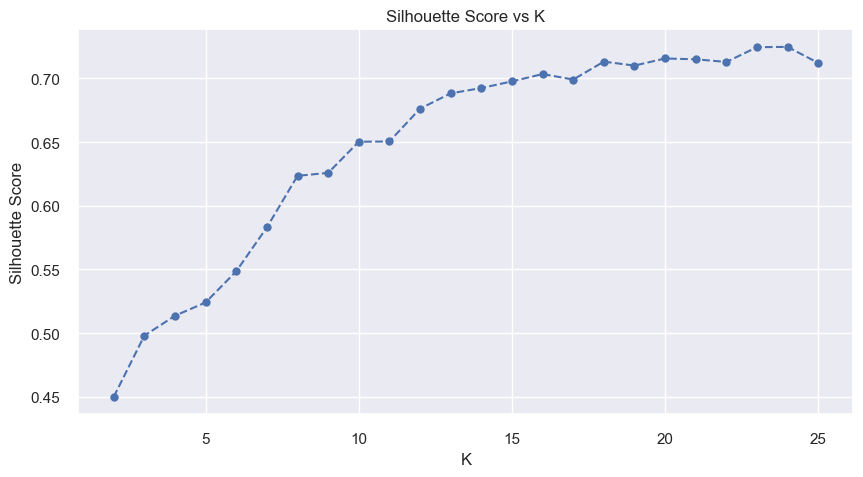

In [170]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score vs K' );

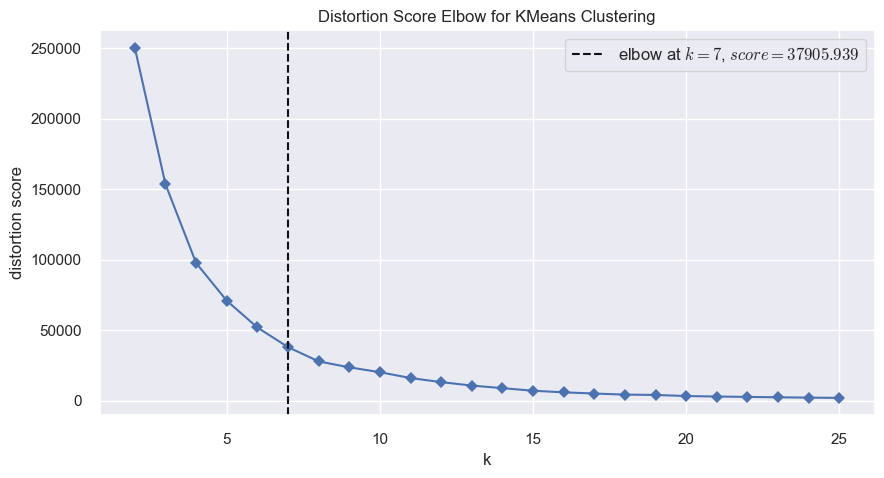

In [171]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Score

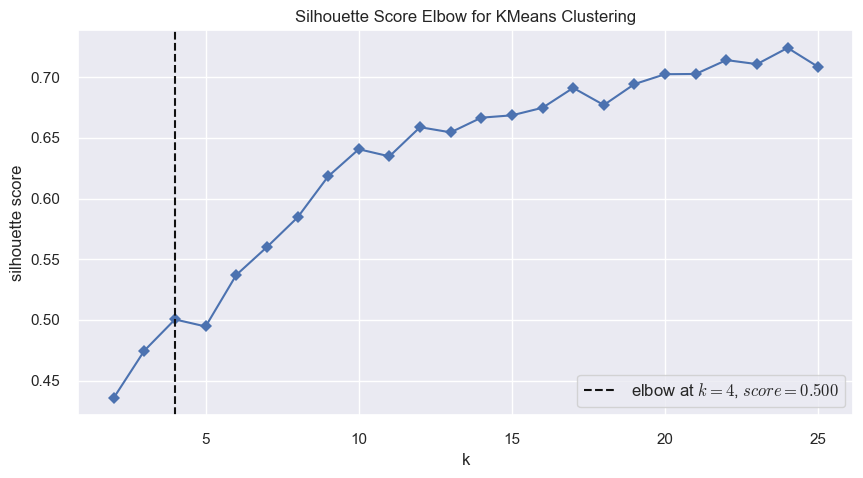

In [74]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), metric='silhouette', k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.3 Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

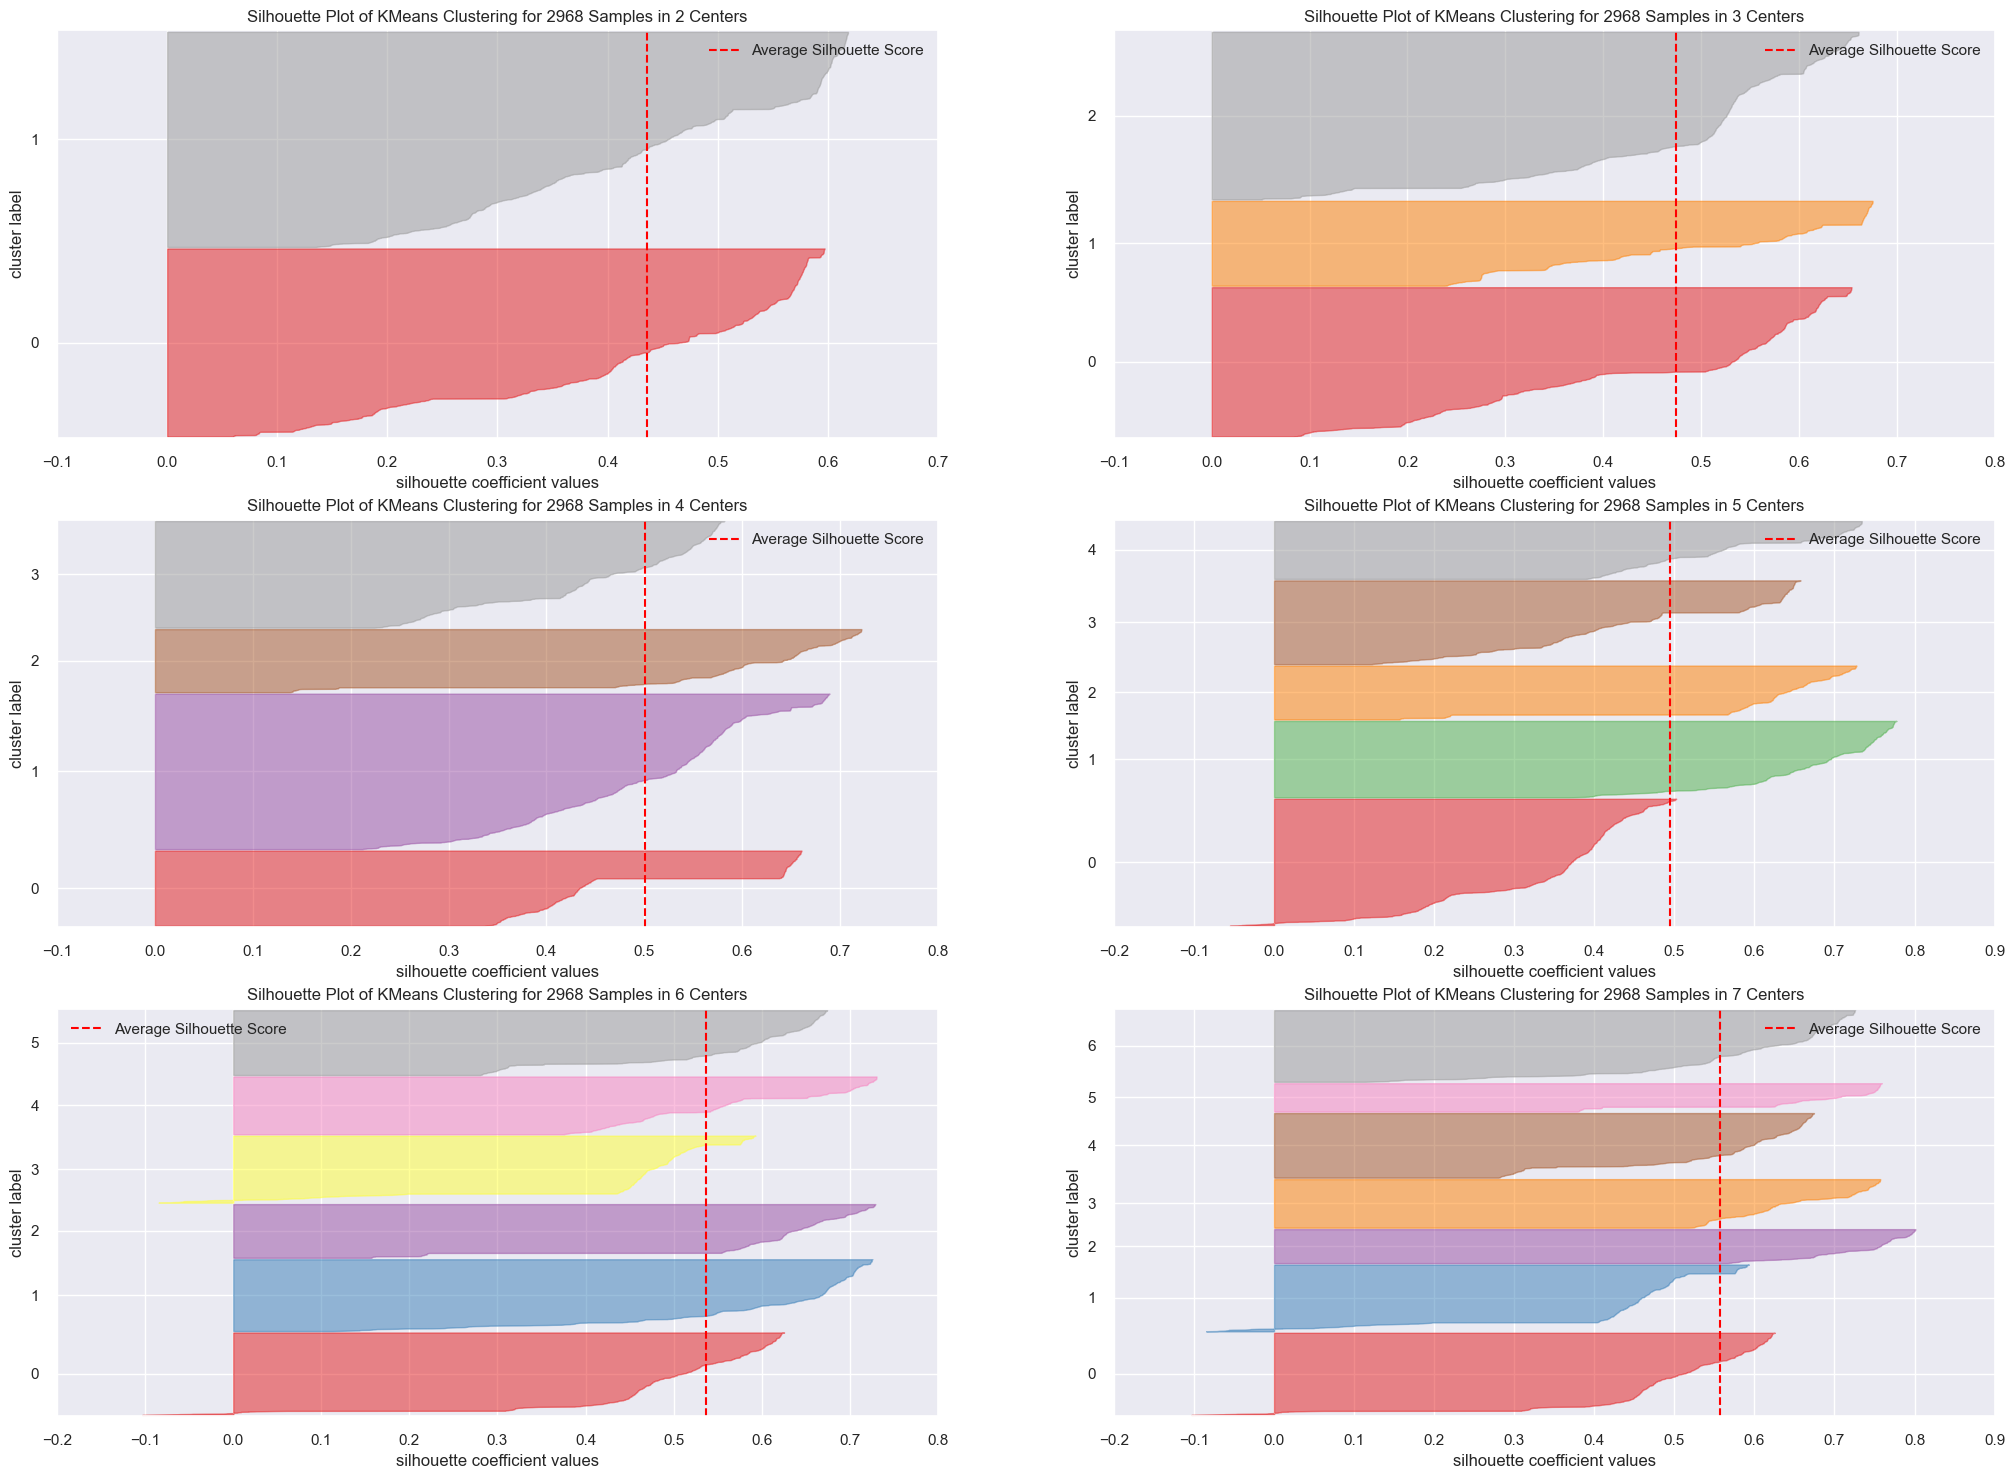

In [75]:
fig, ax = plt.subplots( 3, 2, figsize=( 25, 18 ) )


for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 7.5 GMM

In [172]:
gmm_list = []
for k in clusters:
    # Model Definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # Model Training
    gmm_model.fit( X )

    # Model Predict
    labels = gmm_model.predict( X )

    # Model Performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

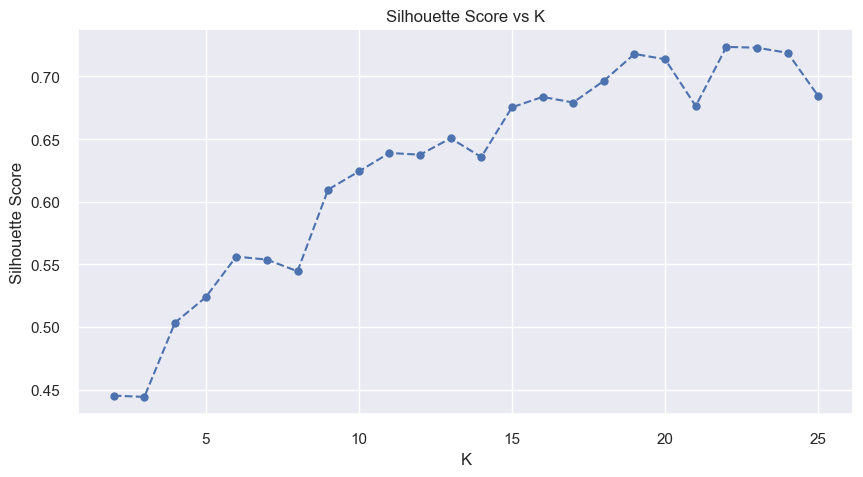

In [173]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score vs K' );

## 7.6 Hierarchical Clustering

In [78]:
# Model Definition and Training
hc_model = hc.linkage( X, 'ward' )

[]

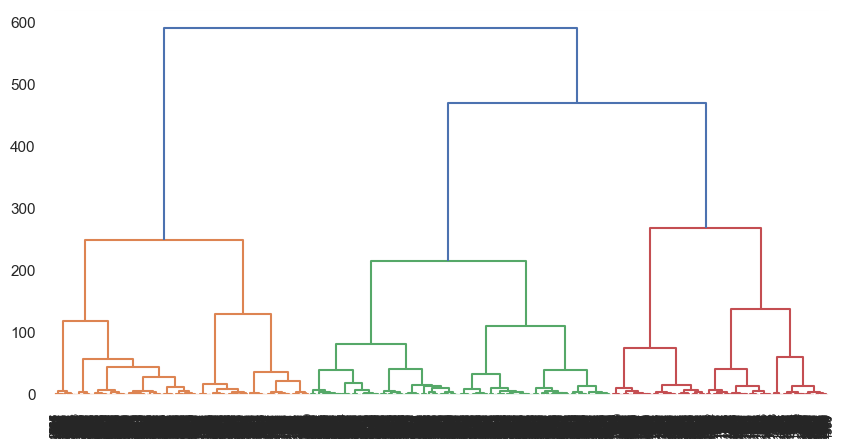

In [79]:
hc.dendrogram( 
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.plot()

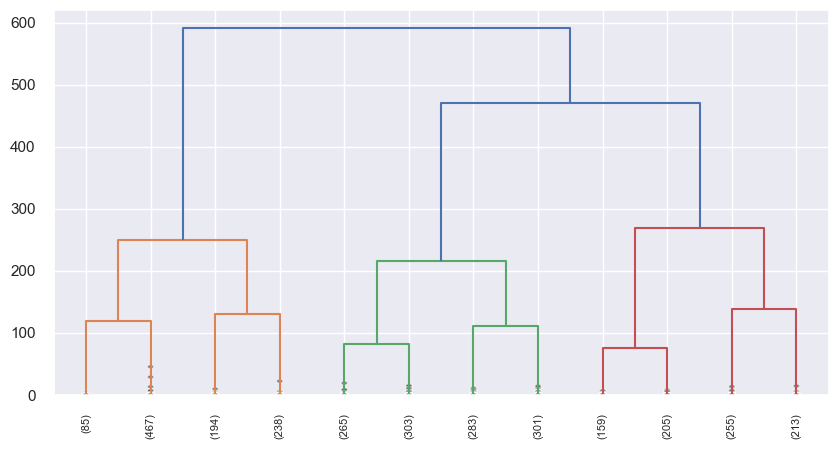

In [80]:
hc.dendrogram(  
    hc_model,
    truncate_mode='lastp',
    p=12,
    show_contracted=True,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.show()

In [81]:
hc_list = []
for k in clusters:
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward' )

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model Performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

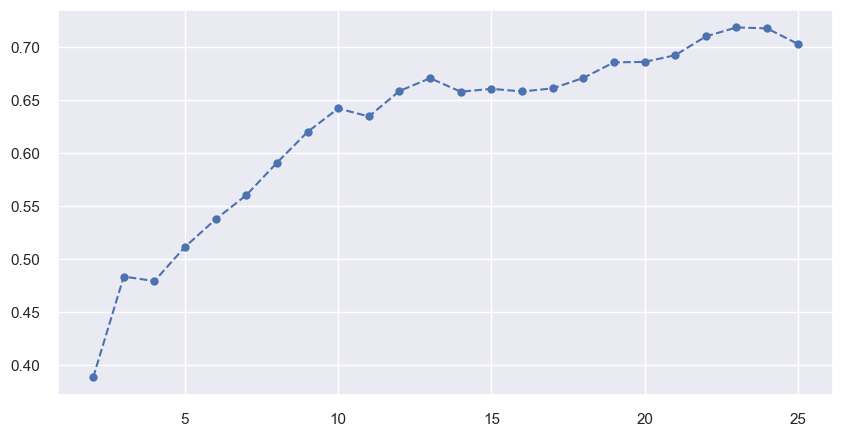

In [82]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' );

## 7.7 DBSCAN

In [174]:
eps=2
min_samples=20

# Model Definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# Model Training and Prediction
labels = dbscan_model.fit_predict( X )

# Model Performance
sil = m.silhouette_score( X, labels, metric='euclidean' )

print( f'Silhouette Score: {sil}' )
print( f'Number of Clusters: { len( unique( labels ) ) }' )
print( unique( labels ) )

Silhouette Score: 0.6376623511314392
Number of Clusters: 15
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [175]:
neighbors = nn( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

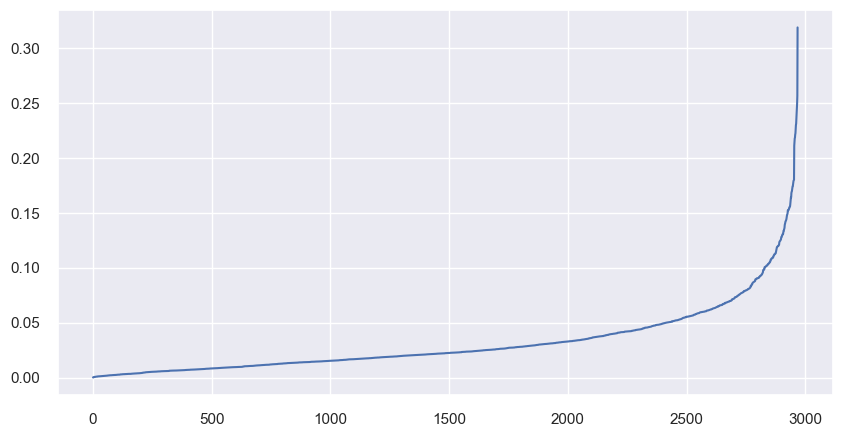

In [176]:
distances = np.sort( distances, axis=0 )
distances = distances[:, 1]
plt.plot( distances )

For K = 2 Silhouette Score: 0.38827988505363464
For K = 3 Silhouette Score: 0.4835885465145111
For K = 4 Silhouette Score: 0.47929564118385315
For K = 5 Silhouette Score: 0.5116379857063293
For K = 6 Silhouette Score: 0.5376756191253662
For K = 7 Silhouette Score: 0.5604771971702576


IndexError: index 3 is out of bounds for axis 0 with size 3

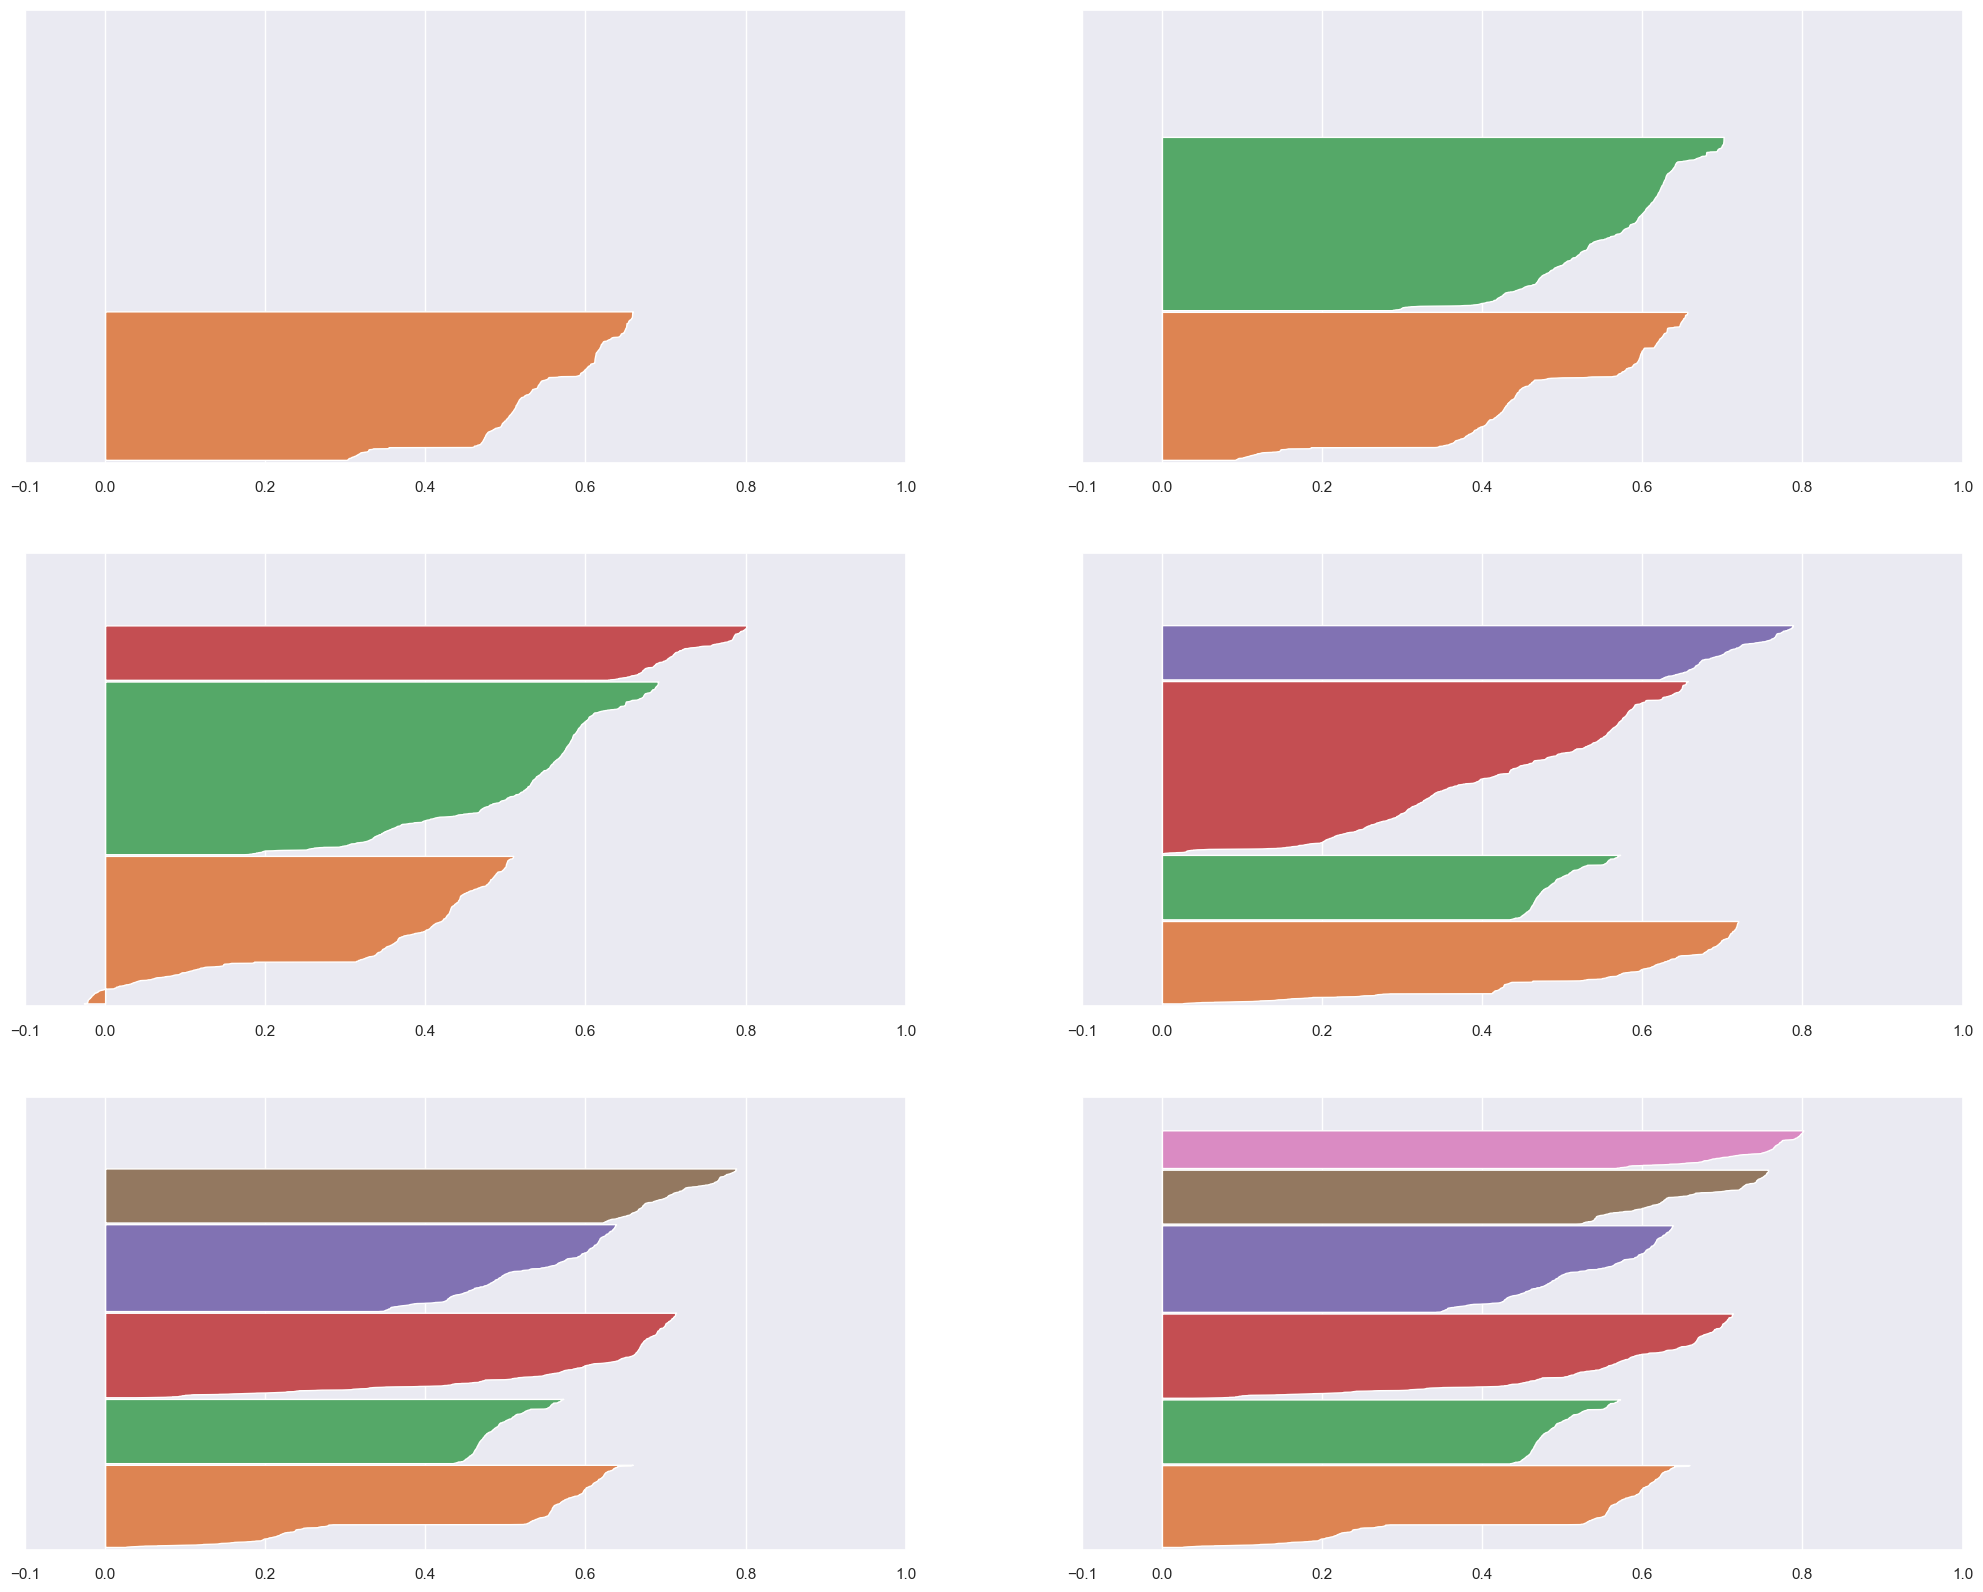

In [86]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )


for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1 ] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k + 1 ) * 10 ] )

    # Model Defition and Training
    hc_model = hc.linkage( X, 'ward' )

    # Model Prediction
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model Performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    print( f'For K = {k} Silhouette Score: {sil}' )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # Select Clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i ]

        # Sort Values
        ith_samples_silhouette_values.sort()

        # Size Cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks( [] )
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1] )

## 7.8 Results

In [177]:
df_results = pd.DataFrame( 
    { 'Kmeans': kmeans_list,
      'GMM': gmm_list,
      'HC': hc_list}
).T

df_results.columns = clusters

In [178]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.449901,0.497988,0.513619,0.524054,0.548533,0.583000,0.623502,0.625797,0.650257,0.650490,0.676213,0.688271,0.692432,0.697652,0.703417,0.699108,0.713175,0.710061,0.715646,0.715010,0.712917,0.724522,0.724748,0.712089
GMM,0.445197,0.444198,0.503446,0.523653,0.556211,0.553790,0.544499,0.609703,0.624130,0.638945,0.637511,0.650672,0.635613,0.675350,0.683653,0.679202,0.696504,0.717967,0.713728,0.676354,0.723603,0.722947,0.718852,0.684342
HC,0.388280,0.483589,0.479296,0.511638,0.537676,0.560477,0.591071,0.620213,0.642339,0.634781,0.658821,0.670929,0.658134,0.660887,0.658399,0.661298,0.671159,0.685850,0.686308,0.692575,0.710373,0.718855,0.717981,0.703343


# 8.0 MODEL TRAINING

In [249]:
# Model Definition
k = 9
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# Model Training
kmeans.fit( X.values )

# Clustering
labels = kmeans.labels_

In [244]:
k = 9
# Model Definition
kmeans = mx.GaussianMixture( n_components=k )

# Model Training
kmeans.fit( X )

# Model Predict
labels = kmeans.predict( X )


In [250]:
# WSS
print( f'WSS value: {kmeans.inertia_:.2f}' )

# SS
print( f'SS value: {m.silhouette_score( X, labels ):.4f}' )

WSS value: 25945.64
SS value: 0.6172


# 9.0 CLUSTER ANALYSIS

In [251]:
df9 = X.copy()
df9['cluster'] = labels

In [252]:
# df9 = df4.copy()
# df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,8.897676,4.112829,2
1,13.182626,10.112639,2
2,11.320426,-6.827398,6
3,-4.451663,10.209073,1
4,-5.639578,-9.377920,5


## 9.1 Visualization Inspection

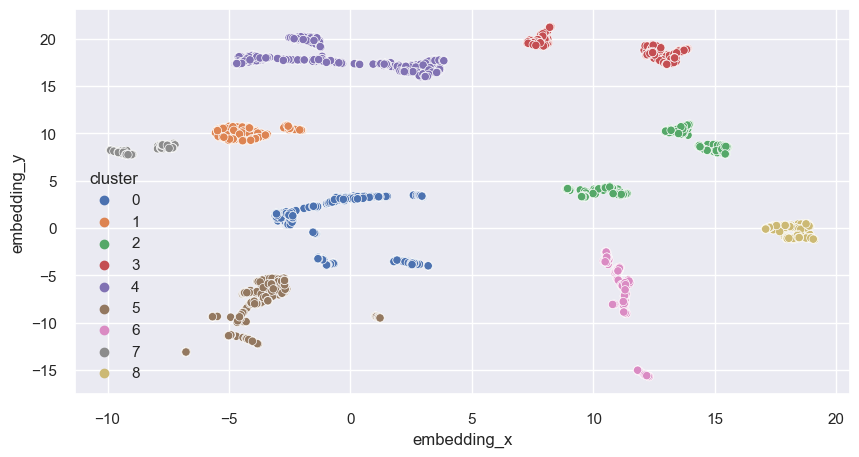

In [253]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep' );

In [95]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
# fig.show()

In [96]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick' )
visualizer.fit( X.values )
visualizer.finalize()

YellowbrickTypeError: The supplied model is not a clustering estimator; try a classifier or regression score visualizer instead!

## 9.2 2D Plot

In [97]:
# df_viz = df9.drop( columns='customer_id', axis=1 )
# sns.pairplot( df_viz, hue='cluster' )

KeyError: "['customer_id'] not found in axis"

## 9.3 UMAP - t-SNE

In [ ]:
# reducer = umap.UMAP( n_neighbors=40, random_state=42 )
# embedding = reducer.fit_transform( X )

# # embedding
# df_viz['embedding_x'] = embedding[:, 0]
# df_viz['embedding_y'] = embedding[:, 1]

# # plot UMAP
# sns.scatterplot( x='embedding_x', y='embedding_y',
#                  hue='cluster', 
#                  palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ), data=df_viz)

## 9.2 Cluster Profile

In [255]:
df92 = df4.copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,invoice_quantity,items_quantity,products_quantity,avg_ticket,returns,avg_recency_days,frequency,avg_unique_basket_size,avg_basket_size,cluster
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,40.0,35.500000,17.000000,8.735294,50.970588,2
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,35.0,27.250000,0.028302,19.000000,154.444444,2
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,50.0,23.187500,0.040323,15.466667,335.200000,6
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,0.0,92.666667,0.017921,5.600000,87.800000,1
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,22.0,8.600000,0.073171,1.000000,26.666667,5


In [258]:
# Number of customers
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg gross revenue 
df_avg_gross = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross, how='inner', on='cluster' )

# Avg recency days
df_avg_recency = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on='cluster' )

# Avg invoice_no
df_avg_invoice = df92[['invoice_quantity', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice, how='inner', on='cluster' )

# Items Quantity
df_items_quantity = df92[['items_quantity', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_items_quantity, how='inner', on='cluster' )

# Avg ticket by cluster
df_avg_ticket_cluster = df92[['cluster', 'avg_ticket']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket_cluster, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['cluster', 'frequency']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_returns = df92[['cluster', 'returns']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_quantity,items_quantity,avg_ticket,frequency,returns
0,0,455,15.330189,530.652286,96.782418,2.525275,261.410989,21.836011,0.224502,6.175824
1,1,250,8.423181,842.106760,70.752000,3.252000,442.652000,21.510499,0.088490,7.184000
2,2,364,12.264151,2589.838654,40.629121,6.719780,1587.629121,26.951001,0.085713,22.862637
3,3,330,11.118598,1799.833091,44.763636,5.242424,1057.775758,29.145175,0.044291,24.006061
4,4,568,19.137466,1217.058891,56.114437,4.093310,675.607394,25.703444,0.060437,13.656690
5,5,414,13.948787,334.180024,111.649758,2.224638,121.630435,28.610854,0.222527,4.900966
6,6,292,9.838275,15086.340479,21.863014,19.277397,9085.732877,94.030086,0.084372,226.229452
7,7,119,4.009434,708.607983,86.966387,2.781513,361.865546,20.938226,0.085591,3.521008
8,8,176,5.929919,3900.387727,27.022727,9.352273,2323.420455,38.596523,0.036884,36.562500


 ### Cluster 1 (Insiders)
    - Representam 0,13% da base.
    - Gastaram $182181,98 na média.
    - Compraram a última vez a 7 dias na média.
    - Compraram 89 itens na média.
    
    
    
### Cluster 2 
    - Representam 99,15% da base.
    - Gastaram em média $1372,57.
    - Compraram a última vez 92 dias atrás na média.
    - Compraram 4 itens na média.



    
### Cluster 3
    - Representam 0,70% da base.
    - Gastaram $40543,51 na média.
    - Compraram a última vez 13 dias atrás na média.
    - Compraram 53 unidades na média.

# 10.0 DEPLOY TO PRODUCTION